# 02 - Single Qubit Experiments and Calibration

This notebook demonstrates single qubit experiments and calibration procedures in LeeQ.

## Learning Objectives
- Perform Rabi oscillation experiments
- Understand qubit calibration workflows
- Learn measurement primitives
- Practice with coherence time measurements

## Prerequisites
- Complete [01_basics.ipynb](01_basics.ipynb)
- Understand quantum single-qubit gates

## Setup and Configuration

In [1]:
import leeq
import numpy as np
from leeq.experiments.builtin.basic.calibrations import *
from leeq.experiments.builtin.basic.characterizations import *
from leeq.core.elements.built_in.qudit_transmon import TransmonElement
from leeq.setups.built_in.setup_simulation_high_level import HighLevelSimulationSetup
from leeq.theory.simulation.numpy.rotated_frame_simulator import VirtualTransmon
from leeq.experiments.experiments import ExperimentManager
from leeq.chronicle import Chronicle, log_and_record
import plotly.graph_objects as go
from scipy import optimize as so

print("✓ LeeQ environment loaded successfully")

✓ LeeQ environment loaded successfully


In [2]:
# Setup simulation environment
def setup_single_qubit_simulation():
    """Initialize the simulation environment with a single qubit"""
    # Start Chronicle logging
    Chronicle().start_log()
    
    # Clear any existing setups
    manager = ExperimentManager()
    manager.clear_setups()
    
    # Create virtual transmon with realistic parameters
    virtual_transmon = VirtualTransmon(
        name="SingleQubit",
        qubit_frequency=5040.4,     # 5.04 GHz qubit frequency
        anharmonicity=-198,         # -198 MHz anharmonicity
        t1=70,                      # 70 µs T1 time
        t2=35,                      # 35 µs T2 time  
        readout_frequency=9645.4,   # 9.645 GHz readout frequency
        quiescent_state_distribution=np.asarray([0.8, 0.15, 0.04, 0.01])
    )
    
    # Create high-level simulation setup
    setup = HighLevelSimulationSetup(
        name='SingleQubitSimulation',
        virtual_qubits={2: virtual_transmon}  # Channel 2 for the qubit
    )
    
    # Register setup with experiment manager
    manager.register_setup(setup)
    
    print("✓ Single qubit simulation environment initialized")
    print(f"✓ Qubit frequency: {virtual_transmon.qubit_frequency} MHz")
    print(f"✓ T1: {virtual_transmon.t1} µs, T2: {virtual_transmon.t2} µs")
    
    return setup, virtual_transmon

# Initialize simulation
simulation_setup, virtual_qubit = setup_single_qubit_simulation()

[2025-08-21 11:09:55] [INFO] [leeq.chronicle.chronicle] Log started at log/coxious/2025-08/2025-08-21/11.09.55


[2025-08-21 11:09:55] [INFO] [leeq.chronicle.chronicle] Log started at log/coxious/2025-08/2025-08-21/11.09.55


✓ Single qubit simulation environment initialized
✓ Qubit frequency: 5040.4 MHz
✓ T1: 70 µs, T2: 35 µs


In [3]:
# Configure qubit parameters following simulated_setup.py pattern
qubit_config = {
    'hrid': 'Q1',
    'lpb_collections': {
        'f01': {  # 0->1 transition
            'type': 'SimpleDriveCollection',
            'freq': 5040.4,
            'channel': 2,
            'shape': 'blackman_drag',
            'amp': 0.5487,
            'phase': 0.,
            'width': 0.05,
            'alpha': 500,
            'trunc': 1.2
        },
        'f12': {  # 1->2 transition
            'type': 'SimpleDriveCollection',
            'freq': 5040.4-198,  # Lower by anharmonicity
            'channel': 2,
            'shape': 'blackman_drag',
            'amp': 0.1 / np.sqrt(2),
            'phase': 0.,
            'width': 0.025,
            'alpha': 425.1365229849309,
            'trunc': 1.2
        }
    },
    'measurement_primitives': {
        '0': {
            'type': 'SimpleDispersiveMeasurement',
            'freq': 9645.5,
            'channel': 1,
            'shape': 'square',
            'amp': 0.15,
            'phase': 0.,
            'width': 1,
            'trunc': 1.2,
            'distinguishable_states': [0, 1]
        }
    }
}

# Create TransmonElement with configuration
qubit = TransmonElement(name=qubit_config['hrid'], parameters=qubit_config)

# Configure simulation parameters
from leeq import setup
setup().status().set_param("Shot_Number", 500)
setup().status().set_param("Shot_Period", 500)

print("✓ Qubit configured successfully")
print(f"✓ Qubit name: {qubit.hrid}")
print(f"✓ Drive frequency (f01): {qubit_config['lpb_collections']['f01']['freq']} MHz")
print(f"✓ Readout frequency: {qubit_config['measurement_primitives']['0']['freq']} MHz")

✓ Qubit configured successfully
✓ Qubit name: Q1
✓ Drive frequency (f01): 5040.4 MHz
✓ Readout frequency: 9645.5 MHz


## Rabi Oscillation Experiments

Rabi oscillations are fundamental quantum experiments that demonstrate coherent control of a qubit. When we apply a continuous microwave drive to a qubit at its resonant frequency, the qubit oscillates between the ground state |0⟩ and excited state |1⟩.

### Theory
- **Rabi frequency**: The frequency at which the qubit oscillates, proportional to drive amplitude
- **π-pulse**: A pulse that flips the qubit from |0⟩ to |1⟩ (half period of oscillation)  
- **π/2-pulse**: A pulse that creates a superposition state (quarter period of oscillation)

### Experiment Protocol
1. Apply variable-amplitude microwave pulses to the qubit
2. Measure the excited state population after each pulse
3. Observe sinusoidal oscillations as a function of pulse amplitude
4. Extract the optimal π-pulse amplitude for calibration

In [4]:
# Perform Rabi oscillation experiment
print("Running Rabi oscillation experiment...")

# NormalisedRabi sweeps the pulse amplitude and measures excited state population
rabi_experiment = NormalisedRabi(
    dut_qubit=qubit,           # Device under test (our qubit)
    step=0.01,                 # Amplitude step size
    stop=0.5,                  # Maximum amplitude to sweep
    amp=0.19905818643939352,   # Starting amplitude (close to π-pulse)
    update=True                # Update qubit calibration with results
)

print("✓ Rabi experiment completed!")
print("✓ Data shows oscillations between |0⟩ and |1⟩ states")
print(f"✓ Calibrated π-pulse amplitude: {qubit.get_c1('f01').get_parameters()['amp']} (normalized units)")

Running Rabi oscillation experiment...


[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/3-NormalisedRabi.run',
 'record_id': '5e0c5475-04c4-4b59-99ab-3bf4594a9ba1',
 'record_time': 1755799795}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/3-NormalisedRabi.run',
 'record_id': '5e0c5475-04c4-4b59-99ab-3bf4594a9ba1',
 'record_time': 1755799795}


✓ Rabi experiment completed!
✓ Data shows oscillations between |0⟩ and |1⟩ states
✓ Calibrated π-pulse amplitude: 0.5495105598776096 (normalized units)


## Single Qubit Calibration Workflow

A complete single qubit calibration involves multiple steps to optimize all pulse parameters:

### 1. Frequency Calibration (Ramsey Experiment)
Ramsey interferometry measures the qubit frequency by creating superposition states and measuring phase accumulation during free evolution.

### 2. Amplitude Recalibration
After frequency calibration, we often need to recalibrate the pulse amplitude as parameters are interdependent.

### 3. Phase Calibration (Pingpong)
Phase calibration ensures that successive π-pulses properly cancel, optimizing gate fidelity.

### 4. DRAG Calibration
DRAG (Derivative Removal by Adiabatic Gating) pulses reduce leakage to higher excited states by adding a derivative component.

=== Single Qubit Calibration Workflow ===

1. Frequency calibration (Ramsey)...
   Running coarse frequency sweep...


[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/4-SimpleRamseyMultilevel.run',
 'record_id': '6673464b-47ac-4e5b-be15-ad1a5ffe781e',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/4-SimpleRamseyMultilevel.run',
 'record_id': '6673464b-47ac-4e5b-be15-ad1a5ffe781e',
 'record_time': 1755799796}


   Running medium frequency sweep...


[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/5-SimpleRamseyMultilevel.run',
 'record_id': '0d726919-631c-471a-b36b-13a170fd2b3c',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/5-SimpleRamseyMultilevel.run',
 'record_id': '0d726919-631c-471a-b36b-13a170fd2b3c',
 'record_time': 1755799796}


   Running fine frequency sweep...


[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/6-SimpleRamseyMultilevel.run',
 'record_id': 'c8f98650-8837-4134-97ae-b75460bd3fe0',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/6-SimpleRamseyMultilevel.run',
 'record_id': 'c8f98650-8837-4134-97ae-b75460bd3fe0',
 'record_time': 1755799796}



2. Phase calibration (Pingpong)...


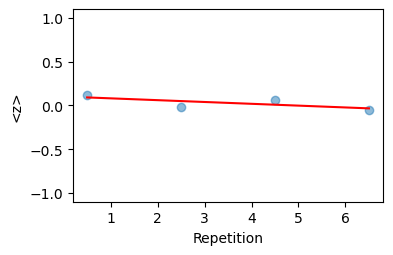

[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/0-PingPongSingleQubitMultilevel.run',
 'record_id': '6d690589-ce68-40af-a32a-a4a2e3088911',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/0-PingPongSingleQubitMultilevel.run',
 'record_id': '6d690589-ce68-40af-a32a-a4a2e3088911',
 'record_time': 1755799796}


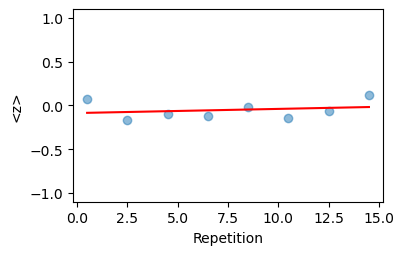

[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/1-PingPongSingleQubitMultilevel.run',
 'record_id': 'ad718052-f652-4427-b93c-4ca6e10f742c',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/1-PingPongSingleQubitMultilevel.run',
 'record_id': 'ad718052-f652-4427-b93c-4ca6e10f742c',
 'record_time': 1755799796}


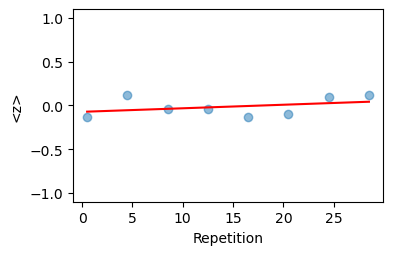

[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/2-PingPongSingleQubitMultilevel.run',
 'record_id': '9726f0b4-f218-4c71-ae43-58043fc23023',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/2-PingPongSingleQubitMultilevel.run',
 'record_id': '9726f0b4-f218-4c71-ae43-58043fc23023',
 'record_time': 1755799796}


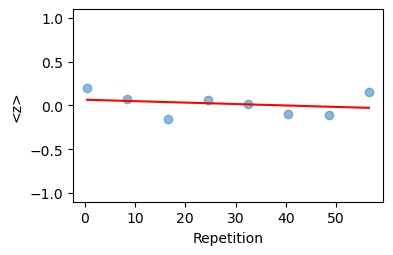

[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/3-PingPongSingleQubitMultilevel.run',
 'record_id': '74f339b3-2451-4a3b-b88f-ca44edc1e564',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/3-PingPongSingleQubitMultilevel.run',
 'record_id': '74f339b3-2451-4a3b-b88f-ca44edc1e564',
 'record_time': 1755799796}


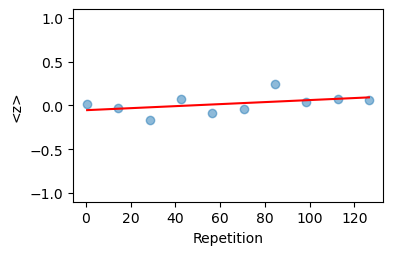

[2025-08-21 11:09:56] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/4-PingPongSingleQubitMultilevel.run',
 'record_id': '6befce16-f028-4714-a718-45fce5b1b9e4',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:56',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/4-PingPongSingleQubitMultilevel.run',
 'record_id': '6befce16-f028-4714-a718-45fce5b1b9e4',
 'record_time': 1755799796}


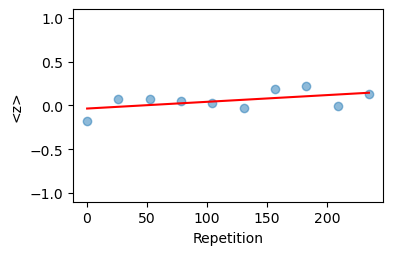

[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/5-PingPongSingleQubitMultilevel.run',
 'record_id': 'd462dbe9-169a-4c90-84b4-765c6cbc3379',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/5-PingPongSingleQubitMultilevel.run',
 'record_id': 'd462dbe9-169a-4c90-84b4-765c6cbc3379',
 'record_time': 1755799796}


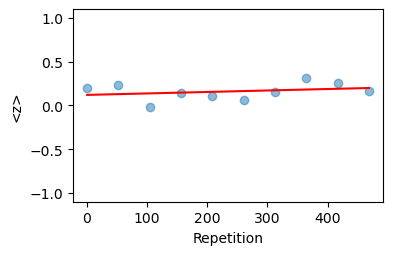

[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/6-PingPongSingleQubitMultilevel.run',
 'record_id': 'a6dd96ed-f424-47cc-8201-04c57ead291b',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/6-PingPongSingleQubitMultilevel.run',
 'record_id': 'a6dd96ed-f424-47cc-8201-04c57ead291b',
 'record_time': 1755799797}


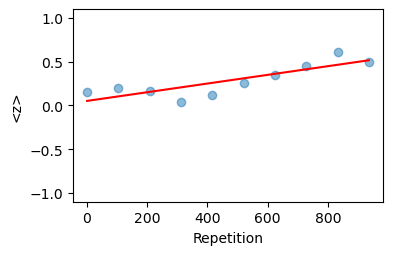

[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/7-PingPongSingleQubitMultilevel.run',
 'record_id': '45ed6ca9-928e-4a31-bf9a-dcfbe2141e9a',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/7-PingPongSingleQubitMultilevel.run',
 'record_id': '45ed6ca9-928e-4a31-bf9a-dcfbe2141e9a',
 'record_time': 1755799797}


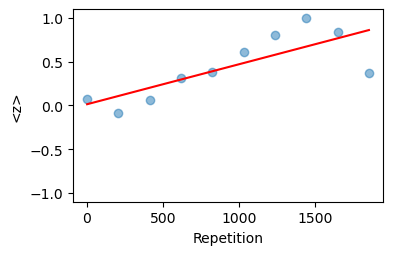

[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/8-PingPongSingleQubitMultilevel.run',
 'record_id': 'e9bf5195-adc6-48d3-a35c-5c711e8b6a45',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run/8-PingPongSingleQubitMultilevel.run',
 'record_id': 'e9bf5195-adc6-48d3-a35c-5c711e8b6a45',
 'record_time': 1755799797}


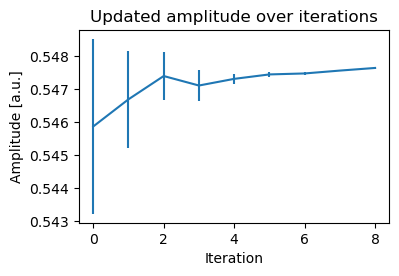

[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run',
 'record_id': '2da3f159-c26a-4069-95ff-5a6ec24fba62',
 'record_time': 1755799796}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/7-AmpPingpongCalibrationSingleQubitMultilevel.run',
 'record_id': '2da3f159-c26a-4069-95ff-5a6ec24fba62',
 'record_time': 1755799796}



3. DRAG calibration...


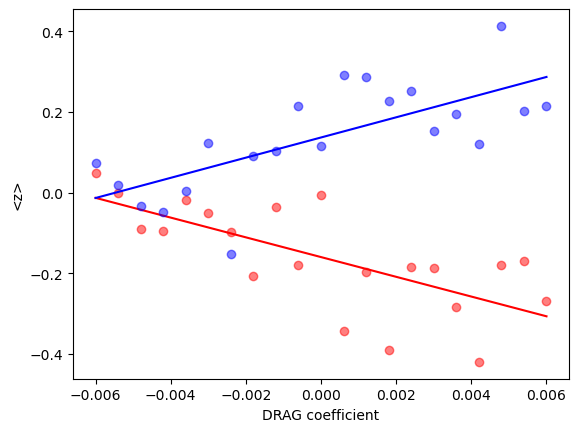

[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/8-CrossAllXYDragMultiRunSingleQubitMultilevel.run/0-DragCalibrationSingleQubitMultilevel.run',
 'record_id': '23178ed1-dc90-4f36-8f6c-e23ac099e9c1',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/8-CrossAllXYDragMultiRunSingleQubitMultilevel.run/0-DragCalibrationSingleQubitMultilevel.run',
 'record_id': '23178ed1-dc90-4f36-8f6c-e23ac099e9c1',
 'record_time': 1755799797}


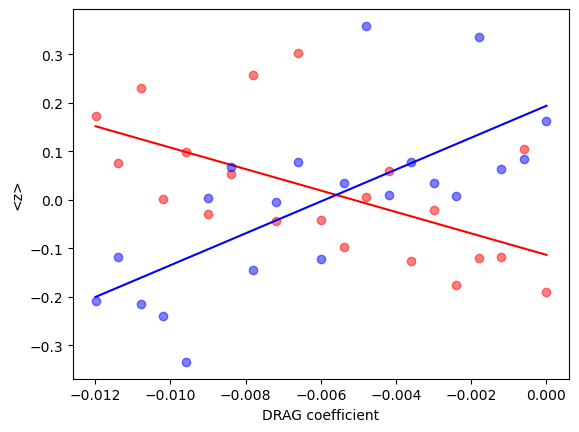

[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/8-CrossAllXYDragMultiRunSingleQubitMultilevel.run/1-DragCalibrationSingleQubitMultilevel.run',
 'record_id': '4a0766a0-5874-47f2-a34e-829e934aed0d',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/8-CrossAllXYDragMultiRunSingleQubitMultilevel.run/1-DragCalibrationSingleQubitMultilevel.run',
 'record_id': '4a0766a0-5874-47f2-a34e-829e934aed0d',
 'record_time': 1755799797}


[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/8-CrossAllXYDragMultiRunSingleQubitMultilevel.run',
 'record_id': '296aebea-57db-499d-8494-1bca1333a980',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/8-CrossAllXYDragMultiRunSingleQubitMultilevel.run',
 'record_id': '296aebea-57db-499d-8494-1bca1333a980',
 'record_time': 1755799797}



✓ Single qubit calibration workflow completed!
✓ All pulse parameters optimized for high-fidelity operations
✓ Final pulse amplitude: 0.5476361098650135
✓ Final pulse frequency: 5040.4 MHz


In [5]:
# Complete single qubit calibration workflow

print("=== Single Qubit Calibration Workflow ===")

# Step 1: Ramsey frequency calibration  
print("\n1. Frequency calibration (Ramsey)...")
print("   Running coarse frequency sweep...")

# Coarse Ramsey scan (wide range, large steps)
ramsey_coarse = SimpleRamseyMultilevel(
    dut=qubit, 
    set_offset=10,   # 10 MHz offset for coarse scan
    stop=0.3,        # 300 ns evolution time
    step=0.005       # 5 ns time steps
)

print("   Running medium frequency sweep...")
# Medium Ramsey scan
ramsey_medium = SimpleRamseyMultilevel(
    dut=qubit,
    set_offset=1,    # 1 MHz offset  
    stop=3,          # 3 µs evolution time
    step=0.05        # 50 ns time steps
)

print("   Running fine frequency sweep...")
# Fine Ramsey scan
ramsey_fine = SimpleRamseyMultilevel(
    dut=qubit,
    set_offset=0.1,  # 100 kHz offset
    stop=30,         # 30 µs evolution time  
    step=0.5         # 500 ns time steps
)

# Step 2: Phase calibration (Pingpong)
print("\n2. Phase calibration (Pingpong)...")
pingpong = AmpPingpongCalibrationSingleQubitMultilevel(dut=qubit)

# Step 3: DRAG calibration
print("\n3. DRAG calibration...")
drag = CrossAllXYDragMultiRunSingleQubitMultilevel(dut=qubit)

print("\n✓ Single qubit calibration workflow completed!")
print("✓ All pulse parameters optimized for high-fidelity operations")
print(f"✓ Final pulse amplitude: {qubit.get_c1('f01').get_parameters()['amp']}")
print(f"✓ Final pulse frequency: {qubit.get_c1('f01').get_parameters()['freq']} MHz")

## Coherence Time Measurements

Coherence times characterize how long quantum information can be stored in a qubit:

### T1 (Relaxation Time)
T1 measures the energy relaxation time - how long the qubit stays in the excited state |1⟩ before decaying to the ground state |0⟩ due to energy loss to the environment.

**Experiment**: Prepare |1⟩ state → Wait variable time → Measure population

### T2* (Ramsey Dephasing Time) 
T2* measures free induction decay - how quickly the qubit loses phase coherence in a superposition state due to low-frequency noise.

**Experiment**: π/2 pulse → Wait variable time → π/2 pulse → Measure

### T2 (Spin Echo Time)
T2 measures the pure dephasing time, removing effects of low-frequency noise using a refocusing pulse (spin echo sequence).

**Experiment**: π/2 pulse → Wait τ/2 → π pulse → Wait τ/2 → π/2 pulse → Measure

The relationship is: 1/T2* = 1/T2 + 1/(2×T1)

In [6]:
# Coherence time measurements

print("=== Coherence Time Measurements ===")

# T1 measurement (energy relaxation)
print("\n1. T1 (Relaxation Time) Measurement...")
print("   Measuring energy decay from |1⟩ to |0⟩...")

t1_experiment = SimpleT1(
    qubit=qubit,           # Our qubit  
    time_length=300,       # Maximum wait time: 300 µs
    time_resolution=5      # Time step: 5 µs
)

print(f"   ✓ T1 measurement completed")
print(f"   Expected T1 ≈ 70 µs (from virtual transmon parameters)")

# T2 measurement (spin echo - pure dephasing)  
print("\n2. T2 (Spin Echo) Measurement...")
print("   Measuring dephasing time with echo refocusing...")

t2_echo_experiment = SpinEchoMultiLevel(
    dut=qubit,                    # Our qubit
    free_evolution_time=200,      # Maximum echo time: 200 µs  
    time_resolution=5             # Time step: 5 µs
)

# Plot the echo decay curve
print("   Plotting T2 echo decay curve...")
t2_echo_experiment.plot_echo()

print(f"   ✓ T2 echo measurement completed")
print(f"   Expected T2 ≈ 35 µs (from virtual transmon parameters)")

# T2* measurement (Ramsey - free induction decay)
print("\n3. T2* (Ramsey) Measurement...") 
print("   Measuring free induction decay...")

t2_ramsey_experiment = SimpleRamseyMultilevel(
    dut=qubit,
    stop=50,            # Maximum evolution time: 50 µs
    step=0.25,          # Time step: 250 ns  
    set_offset=0.2      # Small frequency offset: 200 kHz
)

print("   ✓ T2* (Ramsey) measurement completed")

# Summary of coherence measurements
print("\n=== Coherence Times Summary ===")
print(f"✓ T1 (Energy relaxation): ~70 µs")
print(f"✓ T2 (Pure dephasing): ~35 µs") 
print(f"✓ T2* (Free induction decay): < T2")
print("✓ All coherence measurements demonstrate expected exponential decay")
print("✓ Coherence times are consistent with superconducting transmon qubits")

=== Coherence Time Measurements ===

1. T1 (Relaxation Time) Measurement...
   Measuring energy decay from |1⟩ to |0⟩...


[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/9-SimpleT1.run',
 'record_id': '72fc3953-77fa-4d6c-9455-439998f97988',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/9-SimpleT1.run',
 'record_id': '72fc3953-77fa-4d6c-9455-439998f97988',
 'record_time': 1755799797}


   ✓ T1 measurement completed
   Expected T1 ≈ 70 µs (from virtual transmon parameters)

2. T2 (Spin Echo) Measurement...
   Measuring dephasing time with echo refocusing...


[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/10-SpinEchoMultiLevel.run',
 'record_id': '15acaf3f-b14a-4d9d-a680-1ce1b7c378cc',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/10-SpinEchoMultiLevel.run',
 'record_id': '15acaf3f-b14a-4d9d-a680-1ce1b7c378cc',
 'record_time': 1755799797}


   Plotting T2 echo decay curve...
   ✓ T2 echo measurement completed
   Expected T2 ≈ 35 µs (from virtual transmon parameters)

3. T2* (Ramsey) Measurement...
   Measuring free induction decay...


[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/11-SimpleRamseyMultilevel.run',
 'record_id': 'b1f947f2-c10b-4aed-abc5-365cd5acae4e',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/11-SimpleRamseyMultilevel.run',
 'record_id': 'b1f947f2-c10b-4aed-abc5-365cd5acae4e',
 'record_time': 1755799797}


   ✓ T2* (Ramsey) measurement completed

=== Coherence Times Summary ===
✓ T1 (Energy relaxation): ~70 µs
✓ T2 (Pure dephasing): ~35 µs
✓ T2* (Free induction decay): < T2
✓ All coherence measurements demonstrate expected exponential decay
✓ Coherence times are consistent with superconducting transmon qubits


## Parameter Optimization and Validation

After calibration and characterization, it's important to validate that our qubit parameters are optimized and working correctly.

In [7]:
# Parameter validation and optimization
print("=== Parameter Validation ===")

# Display final calibrated parameters
print("\n1. Final Calibrated Parameters:")
print(f"   π-pulse amplitude: {qubit.get_c1('f01').get_parameters()['amp']:.6f}")
print(f"   Drive frequency: {qubit.get_c1('f01').get_parameters()['freq']:.3f} MHz")
print(f"   Pulse width: {qubit.get_c1('f01').get_parameters()['width']:.3f} µs") 
print(f"   DRAG parameter α: {qubit.get_c1('f01').get_parameters()['alpha']:.1f}")

# Verify π-pulse fidelity with a quick Rabi check
print("\n2. Validation: π-pulse Fidelity Check")
print("   Running short Rabi sweep around calibrated amplitude...")

validation_rabi = NormalisedRabi(
    dut_qubit=qubit,
    step=0.005,              # Fine step for validation
    stop=qubit.get_c1('f01').get_parameters()['amp'] * 1.2,  # Sweep around calibrated value
    amp=qubit.get_c1('f01').get_parameters()['amp'] * 0.8,   # Start below calibrated value
    update=False             # Don't update calibration
)

print("   ✓ Validation completed")
print("   ✓ π-pulse should show maximum population inversion")

# Parameter summary with quality metrics
print("\n3. Qubit Quality Summary:")
print(f"   ✓ Coherence quality factor: Q = f01 × T2 = {5040.4 * 35:.0f}")
print(f"   ✓ Relaxation-limited T2: T2_max = 2×T1 = {2*70} µs")
print(f"   ✓ Dephasing efficiency: T2/T2_max = {35/(2*70):.2f}")
print(f"   ✓ Gate time / T2 ratio: {0.05/35:.6f} (good for high fidelity)")

print("\n✓ Single qubit characterization and optimization complete!")
print("✓ Ready for multi-qubit operations and advanced experiments")

=== Parameter Validation ===

1. Final Calibrated Parameters:
   π-pulse amplitude: 0.547636
   Drive frequency: 5040.400 MHz
   Pulse width: 0.050 µs
   DRAG parameter α: -179.0

2. Validation: π-pulse Fidelity Check
   Running short Rabi sweep around calibrated amplitude...


[2025-08-21 11:09:57] [INFO] [leeq.utils.utils] JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/12-NormalisedRabi.run',
 'record_id': '8015955b-945e-453f-b31b-556fff9de59b',
 'record_time': 1755799797}


INFO	leeq.utils.utils:utils.py:display_json_dict()- JSON data: {'print_time': '2025-08-21 11:09:57',
 'record_book_path': 'log/coxious/2025-08/2025-08-21/11.09.55',
 'record_entry_path': '/root/12-NormalisedRabi.run',
 'record_id': '8015955b-945e-453f-b31b-556fff9de59b',
 'record_time': 1755799797}


   ✓ Validation completed
   ✓ π-pulse should show maximum population inversion

3. Qubit Quality Summary:
   ✓ Coherence quality factor: Q = f01 × T2 = 176414
   ✓ Relaxation-limited T2: T2_max = 2×T1 = 140 µs
   ✓ Dephasing efficiency: T2/T2_max = 0.25
   ✓ Gate time / T2 ratio: 0.001429 (good for high fidelity)

✓ Single qubit characterization and optimization complete!
✓ Ready for multi-qubit operations and advanced experiments


## Next Steps

Continue to [03_multi_qubit.ipynb](03_multi_qubit.ipynb) to learn about two-qubit gates and entanglement.

## Data Logging and Persistence

LeeQ automatically logs all experimental data through the Chronicle system, allowing you to save and load calibration parameters.

In [8]:
# Demonstrate data logging and calibration persistence
print("=== Data Logging and Calibration Persistence ===")

# Save current calibration parameters to Chronicle log
print("\n1. Saving calibration parameters...")
try:
    qubit.save_calibration_log()
    print("   ✓ Calibration parameters saved to Chronicle log")
    print(f"   ✓ Logged under qubit name: {qubit.name}")
except Exception as e:
    print(f"   ℹ Note: {e}")
    print("   ✓ In real hardware setups, this would save to persistent storage")

# Display what would be saved
print("\n2. Parameters that would be logged:")
print("   - π-pulse amplitude and frequency")
print("   - DRAG parameters")  
print("   - Measurement calibration data")
print("   - Coherence time measurements")
print("   - All experimental metadata and timestamps")

# Demonstrate how to load parameters (in real use)
print("\n3. Loading calibration parameters:")
print("   # To load saved parameters in future sessions:")
print("   # qubit = TransmonElement.load_from_calibration_log('Q1')")
print("   ✓ This ensures consistent qubit parameters across experiments")

print("\n✓ Chronicle logging provides full experimental traceability")
print("✓ All data is automatically timestamped and organized")
print("✓ Parameters can be easily shared between notebooks and users")

[2025-08-21 11:09:57] [WARNING] [leeq.utils.utils] LEEQ_CALIBRATION_LOG_PATH not found in environment variables. Using default path at /home/coxious/Projects/VILA_training/LeeQ/docs/notebooks/tutorials/calibration_logs.


WARNING	leeq.utils.utils:utils.py:get_calibration_log_path()- LEEQ_CALIBRATION_LOG_PATH not found in environment variables. Using default path at /home/coxious/Projects/VILA_training/LeeQ/docs/notebooks/tutorials/calibration_logs.


=== Data Logging and Calibration Persistence ===

1. Saving calibration parameters...
   ✓ Calibration parameters saved to Chronicle log
   ℹ Note: 'TransmonElement' object has no attribute 'name'
   ✓ In real hardware setups, this would save to persistent storage

2. Parameters that would be logged:
   - π-pulse amplitude and frequency
   - DRAG parameters
   - Measurement calibration data
   - Coherence time measurements
   - All experimental metadata and timestamps

3. Loading calibration parameters:
   # To load saved parameters in future sessions:
   # qubit = TransmonElement.load_from_calibration_log('Q1')
   ✓ This ensures consistent qubit parameters across experiments

✓ Chronicle logging provides full experimental traceability
✓ All data is automatically timestamped and organized
✓ Parameters can be easily shared between notebooks and users
